# Larvae classification

## 1. Definitions

In [1]:
from pathlib import Path

import torch
from dataset import ImageDataLoadBuilder, visualize_larvae_sample
from metrics import cohen_kappa_fn, f1_fn
from models import CustomClassifier
from optim_utils import build_optimizer_and_scheduler
from torch import nn
from torchsummary import summary
from torchvision import transforms
from training import Trainer
from visualize import Visualizer

In [2]:
device = torch.device(0) if torch.cuda.is_available() else torch.device("cpu")

In [3]:
import gc

def clean_memory():
    gc.collect()
    torch.cuda.empty_cache()

clean_memory()

In [4]:
width = 224
height = 224
nchannels = 3
input_size = (height, width)
input_shape = (nchannels, height, width)
num_classes = 2
imagenet_mean, imagenet_std = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)
labels_map = {
    0: "Larvae",
    1: "Non-larvae",
}

## 2. Data ETL

In [5]:
# Regular preprocessing transformation
preparation = transforms.Compose(
    [
        transforms.Resize(
            input_size,
            interpolation=transforms.InterpolationMode.BILINEAR,
            max_size=None,
            antialias=True,
        ),
        transforms.ToTensor(),
        transforms.Normalize(imagenet_mean, imagenet_std),
    ]
)

# Data augmentation transformation
augmentation = transforms.Compose(
    [
        transforms.Resize(
            (300, 300),
            interpolation=transforms.InterpolationMode.BILINEAR,
            max_size=None,
            antialias=True,
        ),
        transforms.RandomAffine(
            degrees=10,
            translate=(0.05, 0.10),
            scale=(0.9, 1.1),
            shear=(-2, 2),
            interpolation=transforms.InterpolationMode.BILINEAR,
            fill=0,
        ),
        transforms.CenterCrop(250),
        preparation,
    ]
)

In [6]:
builder = ImageDataLoadBuilder(
    data_dir=Path("./images/larvae"),
    train_transform=augmentation,
    valid_transform=preparation,
    test_transform=preparation,
)
train_loader, valid_loader, test_loader = builder.get_tvt_splited_dataloaders()

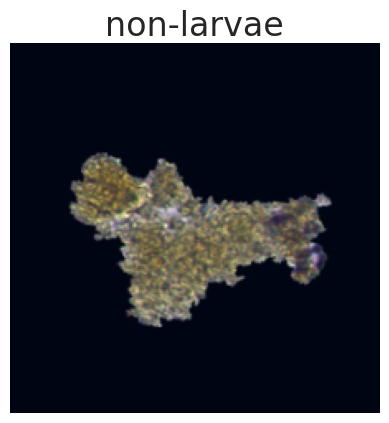

In [7]:
visualize_larvae_sample(train_loader.dataset)

In [8]:
len(train_loader.dataset), len(valid_loader.dataset), len(test_loader.dataset)

(798, 320, 480)

## 3. Training

### 3.1. Criterion

Since larvae data is unbalanced, we will use cross entropy with weights.

In [9]:
from torch import Tensor

N0 = 247
N1 = 1351
weights = Tensor([1.0, N0 / N1])
criterion = nn.CrossEntropyLoss(weight=weights)

optim_config = {
    "scheduler": "onecycle",
    "max_lr": 1e-4,
    "lr": 3e-5,
    "eta_min": 1e-7,
    "weight_decay": 1e-4,
    "warmup_epochs": 5,
}

# criterion = nn.CrossEntropyLoss()

### 3.2. CNN1

In [10]:
cnn_1 = CustomClassifier(
    input_shape=input_shape,
    num_classes=num_classes,
    device=device,
)
summary(cnn_1, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 224, 224]             216
       BatchNorm2d-2          [-1, 8, 224, 224]              16
              ReLU-3          [-1, 8, 224, 224]               0
         MaxPool2d-4          [-1, 8, 112, 112]               0
            Conv2d-5          [-1, 4, 224, 224]             300
       BatchNorm2d-6          [-1, 4, 224, 224]               8
              ReLU-7          [-1, 4, 224, 224]               0
         MaxPool2d-8          [-1, 4, 112, 112]               0
            Conv2d-9          [-1, 4, 224, 224]             588
      BatchNorm2d-10          [-1, 4, 224, 224]               8
             ReLU-11          [-1, 4, 224, 224]               0
        MaxPool2d-12          [-1, 4, 112, 112]               0
           Conv2d-13         [-1, 32, 112, 112]           4,608
      BatchNorm2d-14         [-1, 32, 1

In [11]:
optimizer_cnn_1, scheduler_cnn_1 = build_optimizer_and_scheduler(
    cnn_1,
    optim_config,
    train_loader_len=len(train_loader),
    total_epochs=100,
)
ckpt_cnn_1 = "weights/larvae-adv-cnn-1.pt"
trainer_cnn_1 = Trainer(
    model=cnn_1,
    optimizer=optimizer_cnn_1,
    criterion=criterion,
    device=device,
    scheduler=scheduler_cnn_1,
    checkpoint_path=ckpt_cnn_1,
    patience=10,
    metric_fns=[cohen_kappa_fn, f1_fn],
)

In [12]:
trainer_cnn_1.fit(train_loader, valid_loader, num_epochs=100)

📘 Epoch 1 | Train Loss: 0.6886 | Val Loss: 0.6915 | Train cohen_kappa_fn: 0.0378 | Val cohen_kappa_fn: 0.0310 | Train f1_fn: 0.3497 | Val f1_fn: 0.3077
  🔥 New best model saved!


📘 Epoch 2 | Train Loss: 0.6513 | Val Loss: 0.6817 | Train cohen_kappa_fn: 0.0765 | Val cohen_kappa_fn: 0.0868 | Train f1_fn: 0.3496 | Val f1_fn: 0.3784
  🔥 New best model saved!


📘 Epoch 3 | Train Loss: 0.6313 | Val Loss: 0.6623 | Train cohen_kappa_fn: 0.1499 | Val cohen_kappa_fn: 0.1354 | Train f1_fn: 0.5553 | Val f1_fn: 0.5297
  🔥 New best model saved!


📘 Epoch 4 | Train Loss: 0.6016 | Val Loss: 0.6392 | Train cohen_kappa_fn: 0.1649 | Val cohen_kappa_fn: 0.1415 | Train f1_fn: 0.5717 | Val f1_fn: 0.5416
  🔥 New best model saved!


📘 Epoch 5 | Train Loss: 0.5800 | Val Loss: 0.6086 | Train cohen_kappa_fn: 0.2007 | Val cohen_kappa_fn: 0.1622 | Train f1_fn: 0.6282 | Val f1_fn: 0.5661
  🔥 New best model saved!


📘 Epoch 6 | Train Loss: 0.5603 | Val Loss: 0.5753 | Train cohen_kappa_fn: 0.2806 | Val cohen_kappa_fn: 0.2216 | Train f1_fn: 0.7226 | Val f1_fn: 0.6551
  🔥 New best model saved!


📘 Epoch 7 | Train Loss: 0.5300 | Val Loss: 0.5443 | Train cohen_kappa_fn: 0.3069 | Val cohen_kappa_fn: 0.2630 | Train f1_fn: 0.7573 | Val f1_fn: 0.7033
  🔥 New best model saved!


📘 Epoch 8 | Train Loss: 0.5062 | Val Loss: 0.5110 | Train cohen_kappa_fn: 0.3067 | Val cohen_kappa_fn: 0.2749 | Train f1_fn: 0.7546 | Val f1_fn: 0.7156
  🔥 New best model saved!


📘 Epoch 9 | Train Loss: 0.4768 | Val Loss: 0.4773 | Train cohen_kappa_fn: 0.3434 | Val cohen_kappa_fn: 0.3158 | Train f1_fn: 0.7835 | Val f1_fn: 0.7471
  🔥 New best model saved!


📘 Epoch 10 | Train Loss: 0.4539 | Val Loss: 0.4464 | Train cohen_kappa_fn: 0.4179 | Val cohen_kappa_fn: 0.3908 | Train f1_fn: 0.8365 | Val f1_fn: 0.8088
  🔥 New best model saved!


📘 Epoch 11 | Train Loss: 0.4347 | Val Loss: 0.4254 | Train cohen_kappa_fn: 0.4085 | Val cohen_kappa_fn: 0.3728 | Train f1_fn: 0.8279 | Val f1_fn: 0.8018
  🔥 New best model saved!


📘 Epoch 12 | Train Loss: 0.3974 | Val Loss: 0.3961 | Train cohen_kappa_fn: 0.5829 | Val cohen_kappa_fn: 0.5055 | Train f1_fn: 0.9144 | Val f1_fn: 0.8876
  🔥 New best model saved!


📘 Epoch 13 | Train Loss: 0.3787 | Val Loss: 0.3979 | Train cohen_kappa_fn: 0.4647 | Val cohen_kappa_fn: 0.3446 | Train f1_fn: 0.8562 | Val f1_fn: 0.7765
  ❄️ No improvement, model won't be saved!


📘 Epoch 14 | Train Loss: 0.3617 | Val Loss: 0.3588 | Train cohen_kappa_fn: 0.5925 | Val cohen_kappa_fn: 0.4477 | Train f1_fn: 0.9117 | Val f1_fn: 0.8565
  🔥 New best model saved!


📘 Epoch 15 | Train Loss: 0.3322 | Val Loss: 0.3340 | Train cohen_kappa_fn: 0.6703 | Val cohen_kappa_fn: 0.5947 | Train f1_fn: 0.9385 | Val f1_fn: 0.9180
  🔥 New best model saved!


📘 Epoch 16 | Train Loss: 0.2902 | Val Loss: 0.3238 | Train cohen_kappa_fn: 0.6764 | Val cohen_kappa_fn: 0.5931 | Train f1_fn: 0.9372 | Val f1_fn: 0.9155
  🔥 New best model saved!


📘 Epoch 17 | Train Loss: 0.3003 | Val Loss: 0.3008 | Train cohen_kappa_fn: 0.7065 | Val cohen_kappa_fn: 0.6458 | Train f1_fn: 0.9474 | Val f1_fn: 0.9326
  🔥 New best model saved!


📘 Epoch 18 | Train Loss: 0.2783 | Val Loss: 0.2937 | Train cohen_kappa_fn: 0.7099 | Val cohen_kappa_fn: 0.6458 | Train f1_fn: 0.9472 | Val f1_fn: 0.9326
  🔥 New best model saved!


📘 Epoch 19 | Train Loss: 0.2582 | Val Loss: 0.2854 | Train cohen_kappa_fn: 0.7492 | Val cohen_kappa_fn: 0.6885 | Train f1_fn: 0.9578 | Val f1_fn: 0.9474
  🔥 New best model saved!


📘 Epoch 20 | Train Loss: 0.2524 | Val Loss: 0.3046 | Train cohen_kappa_fn: 0.7278 | Val cohen_kappa_fn: 0.5666 | Train f1_fn: 0.9483 | Val f1_fn: 0.9069
  ❄️ No improvement, model won't be saved!


📘 Epoch 21 | Train Loss: 0.2323 | Val Loss: 0.2792 | Train cohen_kappa_fn: 0.7686 | Val cohen_kappa_fn: 0.6973 | Train f1_fn: 0.9608 | Val f1_fn: 0.9493
  🔥 New best model saved!


📘 Epoch 22 | Train Loss: 0.2245 | Val Loss: 0.2794 | Train cohen_kappa_fn: 0.6884 | Val cohen_kappa_fn: 0.5864 | Train f1_fn: 0.9365 | Val f1_fn: 0.9134
  ❄️ No improvement, model won't be saved!


📘 Epoch 23 | Train Loss: 0.2007 | Val Loss: 0.2627 | Train cohen_kappa_fn: 0.8138 | Val cohen_kappa_fn: 0.6973 | Train f1_fn: 0.9674 | Val f1_fn: 0.9493
  🔥 New best model saved!


📘 Epoch 24 | Train Loss: 0.1895 | Val Loss: 0.2648 | Train cohen_kappa_fn: 0.8531 | Val cohen_kappa_fn: 0.7531 | Train f1_fn: 0.9760 | Val f1_fn: 0.9610
  ❄️ No improvement, model won't be saved!


📘 Epoch 25 | Train Loss: 0.1870 | Val Loss: 0.3076 | Train cohen_kappa_fn: 0.8558 | Val cohen_kappa_fn: 0.7900 | Train f1_fn: 0.9778 | Val f1_fn: 0.9688
  ❄️ No improvement, model won't be saved!


📘 Epoch 26 | Train Loss: 0.1708 | Val Loss: 0.4388 | Train cohen_kappa_fn: 0.7865 | Val cohen_kappa_fn: 0.7373 | Train f1_fn: 0.9710 | Val f1_fn: 0.9638
  ❄️ No improvement, model won't be saved!


📘 Epoch 27 | Train Loss: 0.1563 | Val Loss: 0.2436 | Train cohen_kappa_fn: 0.7976 | Val cohen_kappa_fn: 0.7019 | Train f1_fn: 0.9633 | Val f1_fn: 0.9492
  🔥 New best model saved!


📘 Epoch 28 | Train Loss: 0.1499 | Val Loss: 0.2862 | Train cohen_kappa_fn: 0.9020 | Val cohen_kappa_fn: 0.7831 | Train f1_fn: 0.9843 | Val f1_fn: 0.9668
  ❄️ No improvement, model won't be saved!


📘 Epoch 29 | Train Loss: 0.1193 | Val Loss: 0.2519 | Train cohen_kappa_fn: 0.8245 | Val cohen_kappa_fn: 0.7730 | Train f1_fn: 0.9688 | Val f1_fn: 0.9649
  ❄️ No improvement, model won't be saved!


📘 Epoch 30 | Train Loss: 0.1344 | Val Loss: 0.3397 | Train cohen_kappa_fn: 0.8994 | Val cohen_kappa_fn: 0.7900 | Train f1_fn: 0.9844 | Val f1_fn: 0.9688
  ❄️ No improvement, model won't be saved!


📘 Epoch 31 | Train Loss: 0.1211 | Val Loss: 1.0097 | Train cohen_kappa_fn: 0.6675 | Val cohen_kappa_fn: 0.3962 | Train f1_fn: 0.9594 | Val f1_fn: 0.9375
  ❄️ No improvement, model won't be saved!


📘 Epoch 32 | Train Loss: 0.1338 | Val Loss: 0.2603 | Train cohen_kappa_fn: 0.7054 | Val cohen_kappa_fn: 0.6977 | Train f1_fn: 0.9395 | Val f1_fn: 0.9470
  ❄️ No improvement, model won't be saved!


📘 Epoch 33 | Train Loss: 0.1073 | Val Loss: 0.4985 | Train cohen_kappa_fn: 0.3410 | Val cohen_kappa_fn: 0.3033 | Train f1_fn: 0.7705 | Val f1_fn: 0.7425
  ❄️ No improvement, model won't be saved!


📘 Epoch 34 | Train Loss: 0.1167 | Val Loss: 0.2882 | Train cohen_kappa_fn: 0.6903 | Val cohen_kappa_fn: 0.5875 | Train f1_fn: 0.9353 | Val f1_fn: 0.9054
  ❄️ No improvement, model won't be saved!


📘 Epoch 35 | Train Loss: 0.1149 | Val Loss: 0.2937 | Train cohen_kappa_fn: 0.8863 | Val cohen_kappa_fn: 0.7867 | Train f1_fn: 0.9812 | Val f1_fn: 0.9667
  ❄️ No improvement, model won't be saved!


📘 Epoch 36 | Train Loss: 0.0951 | Val Loss: 0.3449 | Train cohen_kappa_fn: 0.9157 | Val cohen_kappa_fn: 0.7900 | Train f1_fn: 0.9866 | Val f1_fn: 0.9688
  ❄️ No improvement, model won't be saved!


📘 Epoch 37 | Train Loss: 0.0852 | Val Loss: 0.2484 | Train cohen_kappa_fn: 0.8484 | Val cohen_kappa_fn: 0.7193 | Train f1_fn: 0.9734 | Val f1_fn: 0.9508
  ❄️ No improvement, model won't be saved!
⏹️ Early stopping triggered.


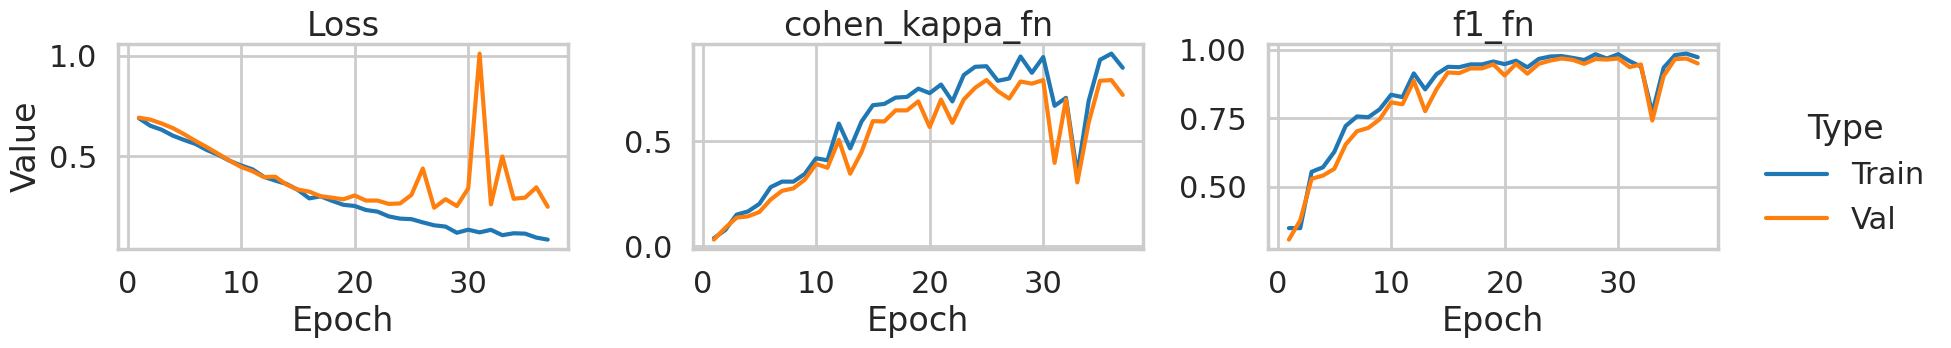

In [13]:
trainer_cnn_1.plot_epochs()

In [14]:
trainer_cnn_1.test(test_loader)

📦 Loading best model...
✅ Done!
Test Loss: 0.2057 | Test cohen_kappa_fn: 0.7603 | Test f1_fn: 0.9600


#### Visualization

In [15]:
visualizer_1 = Visualizer(model=trainer_cnn_1.model, device=device, labels_map=labels_map)

In [16]:
# Display layer representations
visualizer_1.display_layer_representations(test_loader)

KeyboardInterrupt: 

  Generating heatmap for Non-larvae...
  Predicted label is Non-larvae!


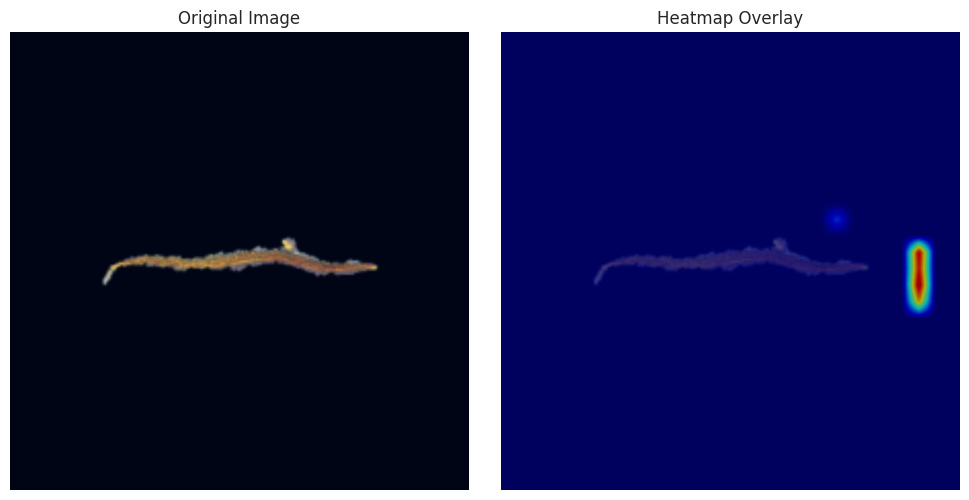

  Generating heatmap for Larvae...
  Predicted label is Larvae!


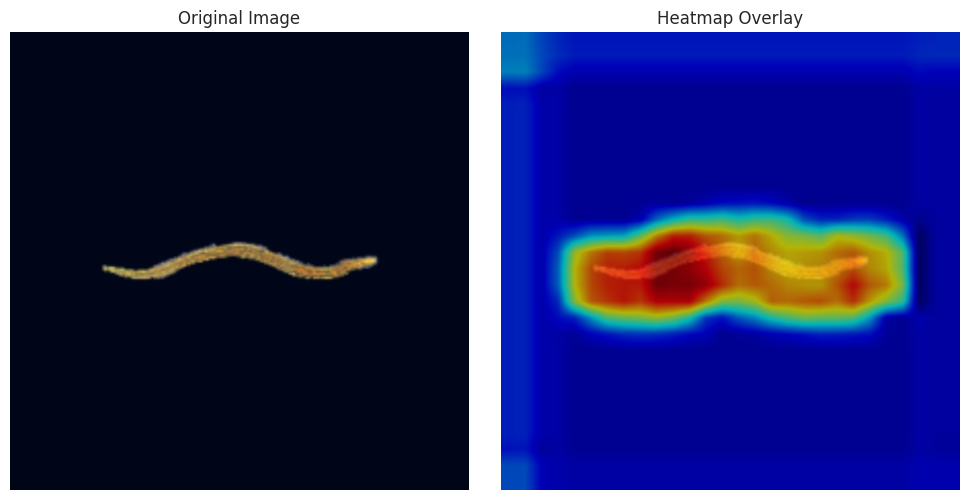

In [ ]:
# Display a heatmap for a single larvae sample and a single non-larvae sample
larvae_done = False
non_larvae_done = False
for sample_img, target in test_loader.dataset:
    if not larvae_done and target == 0:  # Larvae
        larvae_done = True
        visualizer_1.display_heatmap(sample_img, target)
    elif not non_larvae_done and target == 1:  # Non-larvae
        non_larvae_done = True
        visualizer_1.display_heatmap(sample_img, target)
    if larvae_done and non_larvae_done:
        break

In [ ]:
cnn_2 = EnhancedCNNClassifier(
    input_shape=input_shape,
    num_classes=num_classes,
    block_type="se",
    device=device,
)
summary(cnn_2, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             448
              ReLU-2         [-1, 16, 224, 224]               0
 AdaptiveAvgPool2d-3             [-1, 16, 1, 1]               0
            Linear-4                    [-1, 1]              17
              ReLU-5                    [-1, 1]               0
            Linear-6                   [-1, 16]              32
           Sigmoid-7                   [-1, 16]               0
           SEBlock-8         [-1, 16, 224, 224]               0
         MaxPool2d-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 32, 112, 112]           4,640
             ReLU-11         [-1, 32, 112, 112]               0
AdaptiveAvgPool2d-12             [-1, 32, 1, 1]               0
           Linear-13                    [-1, 2]              66
             ReLU-14                   

In [ ]:
optimizer_cnn_2, scheduler_cnn_2 = build_optimizer_and_scheduler(
    cnn_2,
    optim_config,
    train_loader_len=len(train_loader),
    total_epochs=60,
)
ckpt_cnn_2 = "weights/larvae-adv-cnn-2.pt"
trainer_cnn_2 = Trainer(
    model=cnn_2,
    optimizer=optimizer_cnn_2,
    criterion=criterion,
    device=device,
    scheduler=scheduler_cnn_2,
    checkpoint_path=ckpt_cnn_2,
    patience=5,
    metric_fns=[cohen_kappa_fn, f1_fn],
)

In [ ]:
trainer_cnn_2.fit(train_loader, valid_loader, num_epochs=60)

❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 1 | Train Loss: 0.6932 | Val Loss: 0.6931 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000
  🔥 New best model saved!


❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 2 | Train Loss: 0.6931 | Val Loss: 0.6931 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000
  ❄️ No improvement, model won't be saved!


❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 3 | Train Loss: 0.6931 | Val Loss: 0.6931 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000
  ❄️ No improvement, model won't be saved!


❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 4 | Train Loss: 0.6931 | Val Loss: 0.6931 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000
  🔥 New best model saved!


❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 5 | Train Loss: 0.6931 | Val Loss: 0.6931 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000
  🔥 New best model saved!


❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 6 | Train Loss: 0.6931 | Val Loss: 0.6931 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000
  ❄️ No improvement, model won't be saved!


❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 7 | Train Loss: 0.6931 | Val Loss: 0.6931 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000
  ❄️ No improvement, model won't be saved!


❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 8 | Train Loss: 0.6932 | Val Loss: 0.6931 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000
  ❄️ No improvement, model won't be saved!


❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 9 | Train Loss: 0.6932 | Val Loss: 0.6931 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000
  ❄️ No improvement, model won't be saved!


❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 10 | Train Loss: 0.6932 | Val Loss: 0.6931 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000
  ❄️ No improvement, model won't be saved!
⏹️ Early stopping triggered.


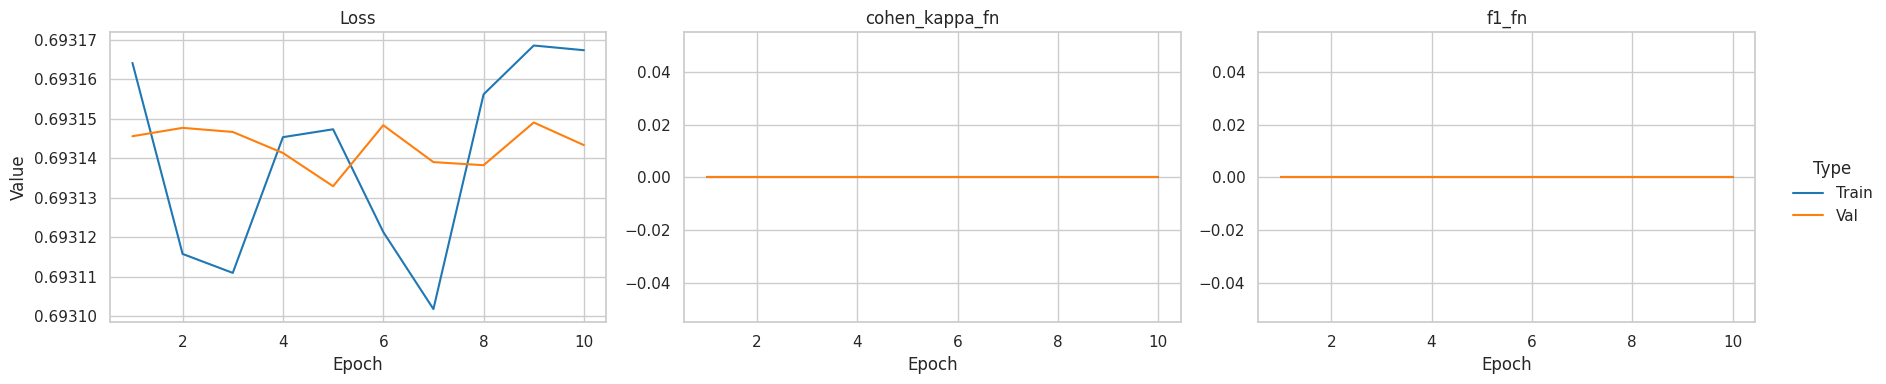

In [ ]:
trainer_cnn_2.plot_epochs()

In [ ]:
trainer_cnn_2.test(test_loader)

📦 Loading best model...
✅ Done!
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
Test Loss: 0.6931 | Test cohen_kappa_fn: 0.0000 | Test f1_fn: 0.0000


#### Visualization

In [ ]:
visualizer_2 = Visualizer(model=trainer_cnn_2.model, device=device, labels_map=labels_map)

In [ ]:
# Display layer representations
# visualizer_2.display_layer_representations(test_loader)

  Generating heatmap for Non-larvae...
  Predicted label is Non-larvae!


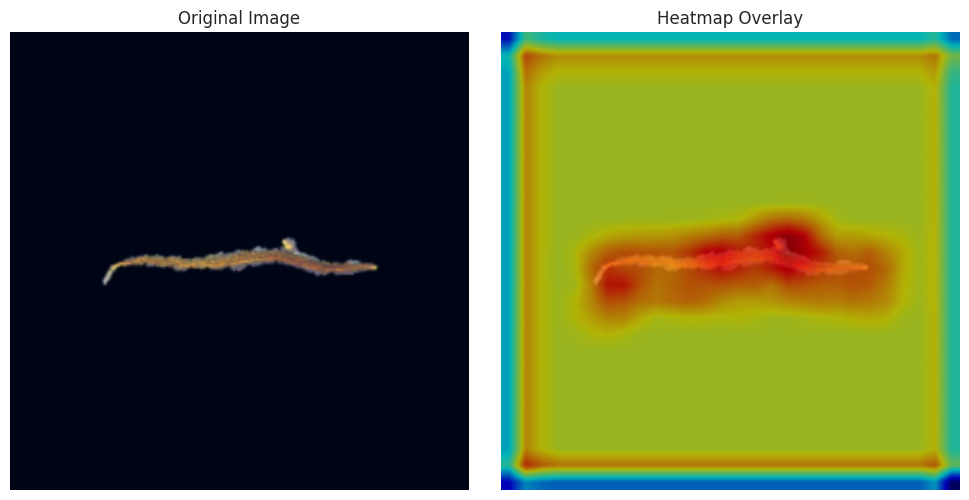

  Generating heatmap for Larvae...
  Predicted label is Non-larvae!


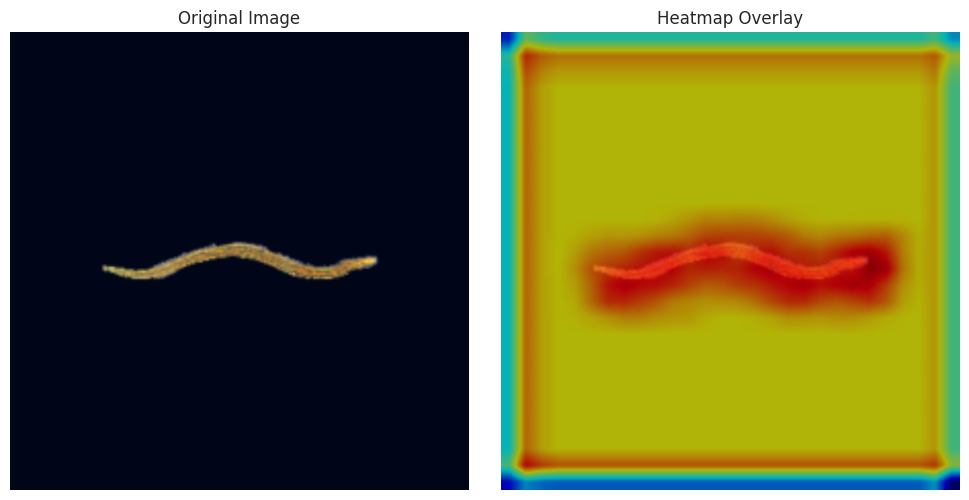

In [ ]:
# Display a heatmap for a single larvae sample and a single non-larvae sample
larvae_done = False
non_larvae_done = False
for sample_img, target in test_loader.dataset:
    if not larvae_done and target == 0:  # Larvae
        larvae_done = True
        visualizer_2.display_heatmap(sample_img, target)
    elif not non_larvae_done and target == 1:  # Non-larvae
        non_larvae_done = True
        visualizer_2.display_heatmap(sample_img, target)
    if larvae_done and non_larvae_done:
        break

In [ ]:
cnn_3 = EnhancedCNNClassifier(
    input_shape=input_shape,
    num_classes=num_classes,
    block_type="cbam",
    device=device,
)
summary(cnn_3, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             448
              ReLU-2         [-1, 16, 224, 224]               0
 AdaptiveMaxPool2d-3             [-1, 16, 1, 1]               0
 AdaptiveAvgPool2d-4             [-1, 16, 1, 1]               0
            Conv2d-5              [-1, 1, 1, 1]              16
              ReLU-6              [-1, 1, 1, 1]               0
            Conv2d-7             [-1, 16, 1, 1]              16
            Conv2d-8              [-1, 1, 1, 1]              16
              ReLU-9              [-1, 1, 1, 1]               0
           Conv2d-10             [-1, 16, 1, 1]              16
          Sigmoid-11             [-1, 16, 1, 1]               0
 ChannelAttention-12             [-1, 16, 1, 1]               0
           Conv2d-13          [-1, 1, 224, 224]              99
          Sigmoid-14          [-1, 1, 2

In [ ]:
cbam_optim_config = {
    "scheduler": "onecycle",
    "max_lr": 1e-3,
    "lr": 3e-4,
    "eta_min": 5e-6,
    "weight_decay": 1e-4,
    "warmup_epochs": 6,
}
optimizer_cnn_3, scheduler_cnn_3 = build_optimizer_and_scheduler(
    cnn_3,
    cbam_optim_config,
    train_loader_len=len(train_loader),
    total_epochs=60,
)
ckpt_cnn_3 = "weights/larvae-adv-cnn-3.pt"
trainer_cnn_3 = Trainer(
    model=cnn_3,
    optimizer=optimizer_cnn_3,
    criterion=criterion,
    device=device,
    scheduler=scheduler_cnn_3,
    checkpoint_path=ckpt_cnn_3,
    patience=5,
    metric_fns=[cohen_kappa_fn, f1_fn],
)

In [ ]:
trainer_cnn_3.fit(train_loader, valid_loader, num_epochs=60)

❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 1 | Train Loss: 0.6936 | Val Loss: 0.6931 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000
  🔥 New best model saved!


❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 2 | Train Loss: 0.6930 | Val Loss: 0.6929 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000
  🔥 New best model saved!


❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 3 | Train Loss: 0.6929 | Val Loss: 0.6928 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000
  🔥 New best model saved!


❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 4 | Train Loss: 0.6924 | Val Loss: 0.6923 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000
  🔥 New best model saved!


❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 5 | Train Loss: 0.6917 | Val Loss: 0.6911 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000
  🔥 New best model saved!


📘 Epoch 6 | Train Loss: 0.6899 | Val Loss: 0.6871 | Train cohen_kappa_fn: -0.0229 | Val cohen_kappa_fn: -0.0087 | Train f1_fn: 0.8703 | Val f1_fn: 0.8858
  🔥 New best model saved!


📘 Epoch 7 | Train Loss: 0.6809 | Val Loss: 0.6801 | Train cohen_kappa_fn: -0.0325 | Val cohen_kappa_fn: 0.0082 | Train f1_fn: 0.9022 | Val f1_fn: 0.9094
  🔥 New best model saved!


📘 Epoch 8 | Train Loss: 0.6667 | Val Loss: 0.6574 | Train cohen_kappa_fn: 0.0733 | Val cohen_kappa_fn: 0.0421 | Train f1_fn: 0.7404 | Val f1_fn: 0.7474
  🔥 New best model saved!


📘 Epoch 9 | Train Loss: 0.6416 | Val Loss: 0.6384 | Train cohen_kappa_fn: 0.1590 | Val cohen_kappa_fn: 0.1081 | Train f1_fn: 0.6107 | Val f1_fn: 0.5765
  🔥 New best model saved!


📘 Epoch 10 | Train Loss: 0.6142 | Val Loss: 0.7213 | Train cohen_kappa_fn: 0.1548 | Val cohen_kappa_fn: 0.1094 | Train f1_fn: 0.7260 | Val f1_fn: 0.7489
  ❄️ No improvement, model won't be saved!


📘 Epoch 11 | Train Loss: 0.5995 | Val Loss: 0.6326 | Train cohen_kappa_fn: 0.1594 | Val cohen_kappa_fn: 0.1295 | Train f1_fn: 0.5774 | Val f1_fn: 0.5602
  🔥 New best model saved!


📘 Epoch 12 | Train Loss: 0.6040 | Val Loss: 0.7193 | Train cohen_kappa_fn: 0.2393 | Val cohen_kappa_fn: 0.1916 | Train f1_fn: 0.7457 | Val f1_fn: 0.7754
  ❄️ No improvement, model won't be saved!


📘 Epoch 13 | Train Loss: 0.5822 | Val Loss: 0.5986 | Train cohen_kappa_fn: 0.1929 | Val cohen_kappa_fn: 0.1792 | Train f1_fn: 0.6339 | Val f1_fn: 0.6386
  🔥 New best model saved!


📘 Epoch 14 | Train Loss: 0.5656 | Val Loss: 0.7093 | Train cohen_kappa_fn: 0.3607 | Val cohen_kappa_fn: 0.2072 | Train f1_fn: 0.9147 | Val f1_fn: 0.9244
  ❄️ No improvement, model won't be saved!


📘 Epoch 15 | Train Loss: 0.5709 | Val Loss: 0.5536 | Train cohen_kappa_fn: 0.2139 | Val cohen_kappa_fn: 0.1994 | Train f1_fn: 0.6541 | Val f1_fn: 0.6650
  🔥 New best model saved!


📘 Epoch 16 | Train Loss: 0.5469 | Val Loss: 0.5252 | Train cohen_kappa_fn: 0.3328 | Val cohen_kappa_fn: 0.4026 | Train f1_fn: 0.7891 | Val f1_fn: 0.8495
  🔥 New best model saved!


📘 Epoch 17 | Train Loss: 0.4958 | Val Loss: 0.5501 | Train cohen_kappa_fn: 0.6437 | Val cohen_kappa_fn: 0.6711 | Train f1_fn: 0.9514 | Val f1_fn: 0.9590
  ❄️ No improvement, model won't be saved!


📘 Epoch 18 | Train Loss: 0.4121 | Val Loss: 0.5820 | Train cohen_kappa_fn: 0.6674 | Val cohen_kappa_fn: 0.6354 | Train f1_fn: 0.9568 | Val f1_fn: 0.9556
  ❄️ No improvement, model won't be saved!


📘 Epoch 19 | Train Loss: 0.4773 | Val Loss: 0.6732 | Train cohen_kappa_fn: 0.6221 | Val cohen_kappa_fn: 0.5393 | Train f1_fn: 0.9545 | Val f1_fn: 0.9472
  ❄️ No improvement, model won't be saved!


📘 Epoch 20 | Train Loss: 0.4809 | Val Loss: 0.4250 | Train cohen_kappa_fn: 0.5359 | Val cohen_kappa_fn: 0.6072 | Train f1_fn: 0.8967 | Val f1_fn: 0.9272
  🔥 New best model saved!


📘 Epoch 21 | Train Loss: 0.4002 | Val Loss: 0.4113 | Train cohen_kappa_fn: 0.4541 | Val cohen_kappa_fn: 0.4672 | Train f1_fn: 0.8538 | Val f1_fn: 0.8689
  🔥 New best model saved!


📘 Epoch 22 | Train Loss: 0.3548 | Val Loss: 0.4200 | Train cohen_kappa_fn: 0.7265 | Val cohen_kappa_fn: 0.7449 | Train f1_fn: 0.9559 | Val f1_fn: 0.9613
  ❄️ No improvement, model won't be saved!


📘 Epoch 23 | Train Loss: 0.3336 | Val Loss: 0.3807 | Train cohen_kappa_fn: 0.4068 | Val cohen_kappa_fn: 0.4379 | Train f1_fn: 0.8269 | Val f1_fn: 0.8518
  🔥 New best model saved!


📘 Epoch 24 | Train Loss: 0.3447 | Val Loss: 0.3394 | Train cohen_kappa_fn: 0.6733 | Val cohen_kappa_fn: 0.6932 | Train f1_fn: 0.9363 | Val f1_fn: 0.9472
  🔥 New best model saved!


📘 Epoch 25 | Train Loss: 0.2920 | Val Loss: 0.3244 | Train cohen_kappa_fn: 0.5124 | Val cohen_kappa_fn: 0.5292 | Train f1_fn: 0.8790 | Val f1_fn: 0.8938
  🔥 New best model saved!


📘 Epoch 26 | Train Loss: 0.3518 | Val Loss: 0.3026 | Train cohen_kappa_fn: 0.5442 | Val cohen_kappa_fn: 0.5418 | Train f1_fn: 0.8918 | Val f1_fn: 0.9008
  🔥 New best model saved!


📘 Epoch 27 | Train Loss: 0.2556 | Val Loss: 0.3070 | Train cohen_kappa_fn: 0.8062 | Val cohen_kappa_fn: 0.7795 | Train f1_fn: 0.9695 | Val f1_fn: 0.9669
  ❄️ No improvement, model won't be saved!


📘 Epoch 28 | Train Loss: 0.2822 | Val Loss: 0.3236 | Train cohen_kappa_fn: 0.7888 | Val cohen_kappa_fn: 0.7434 | Train f1_fn: 0.9656 | Val f1_fn: 0.9591
  ❄️ No improvement, model won't be saved!


📘 Epoch 29 | Train Loss: 0.2076 | Val Loss: 0.4738 | Train cohen_kappa_fn: 0.8569 | Val cohen_kappa_fn: 0.8161 | Train f1_fn: 0.9795 | Val f1_fn: 0.9746
  ❄️ No improvement, model won't be saved!


📘 Epoch 30 | Train Loss: 0.2736 | Val Loss: 0.2867 | Train cohen_kappa_fn: 0.6990 | Val cohen_kappa_fn: 0.6160 | Train f1_fn: 0.9399 | Val f1_fn: 0.9243
  🔥 New best model saved!


📘 Epoch 31 | Train Loss: 0.2008 | Val Loss: 0.4098 | Train cohen_kappa_fn: 0.8398 | Val cohen_kappa_fn: 0.7339 | Train f1_fn: 0.9738 | Val f1_fn: 0.9572
  ❄️ No improvement, model won't be saved!


📘 Epoch 32 | Train Loss: 0.2314 | Val Loss: 0.2689 | Train cohen_kappa_fn: 0.5503 | Val cohen_kappa_fn: 0.5785 | Train f1_fn: 0.8902 | Val f1_fn: 0.9087
  🔥 New best model saved!


📘 Epoch 33 | Train Loss: 0.2710 | Val Loss: 0.3168 | Train cohen_kappa_fn: 0.5478 | Val cohen_kappa_fn: 0.5230 | Train f1_fn: 0.8882 | Val f1_fn: 0.8889
  ❄️ No improvement, model won't be saved!


📘 Epoch 34 | Train Loss: 0.2251 | Val Loss: 0.3082 | Train cohen_kappa_fn: 0.7488 | Val cohen_kappa_fn: 0.6932 | Train f1_fn: 0.9521 | Val f1_fn: 0.9472
  ❄️ No improvement, model won't be saved!


📘 Epoch 35 | Train Loss: 0.1663 | Val Loss: 0.3399 | Train cohen_kappa_fn: 0.3838 | Val cohen_kappa_fn: 0.4753 | Train f1_fn: 0.8035 | Val f1_fn: 0.8595
  ❄️ No improvement, model won't be saved!


📘 Epoch 36 | Train Loss: 0.2435 | Val Loss: 0.4754 | Train cohen_kappa_fn: 0.8828 | Val cohen_kappa_fn: 0.7975 | Train f1_fn: 0.9832 | Val f1_fn: 0.9730
  ❄️ No improvement, model won't be saved!


📘 Epoch 37 | Train Loss: 0.1857 | Val Loss: 0.2852 | Train cohen_kappa_fn: 0.7892 | Val cohen_kappa_fn: 0.7239 | Train f1_fn: 0.9608 | Val f1_fn: 0.9529
  ❄️ No improvement, model won't be saved!
⏹️ Early stopping triggered.


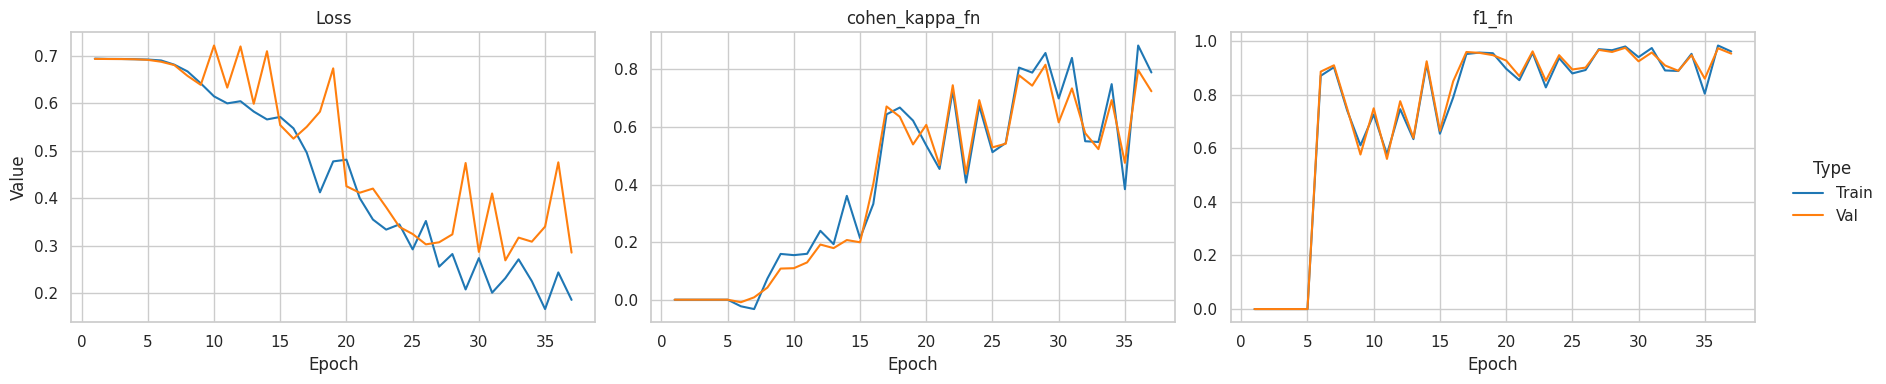

In [ ]:
trainer_cnn_3.plot_epochs()

In [ ]:
trainer_cnn_3.test(test_loader)

📦 Loading best model...
✅ Done!
Test Loss: 0.2102 | Test cohen_kappa_fn: 0.6277 | Test f1_fn: 0.9211


#### Visualization

In [ ]:
visualizer_3 = Visualizer(model=trainer_cnn_3.model, device=device, labels_map=labels_map)

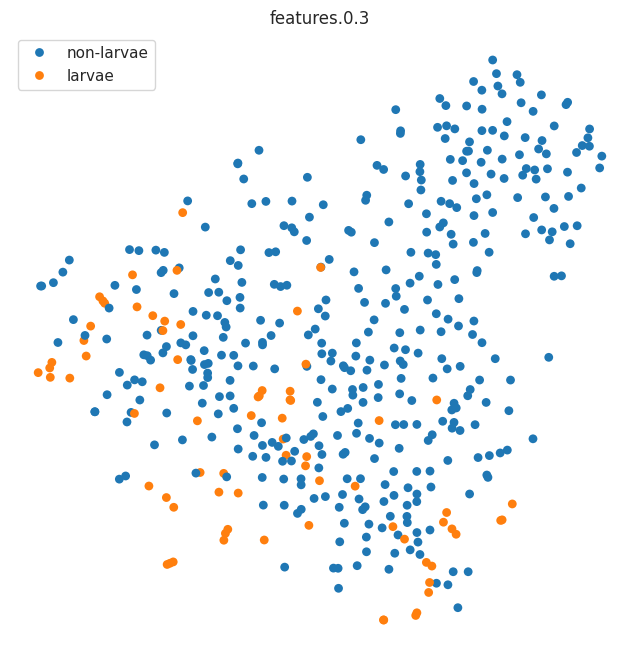

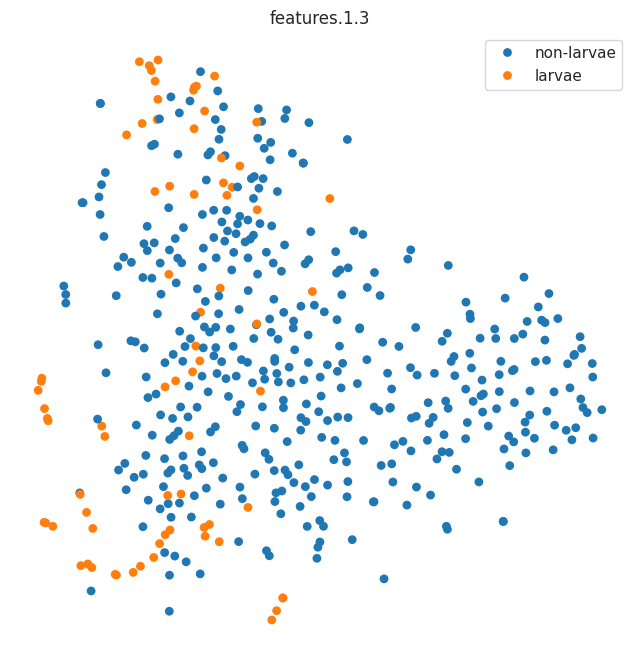

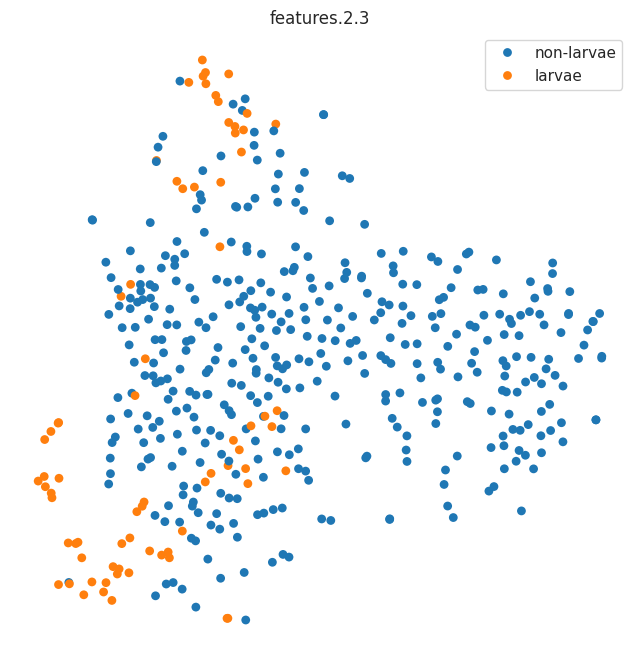

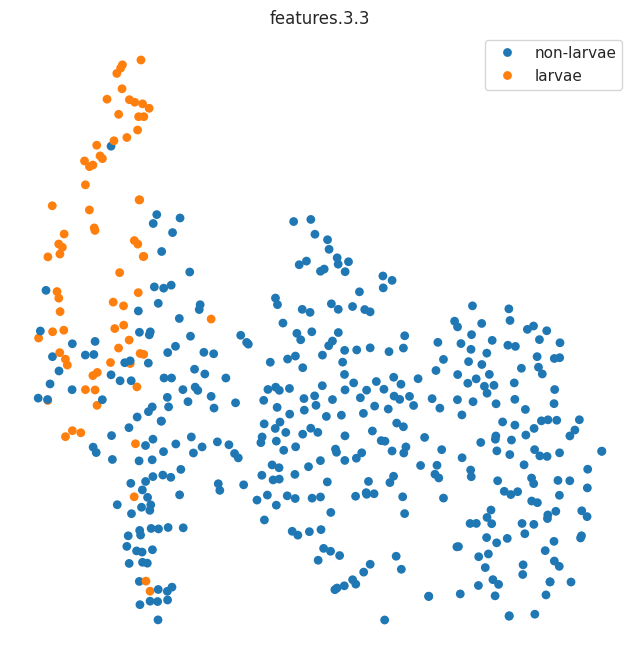

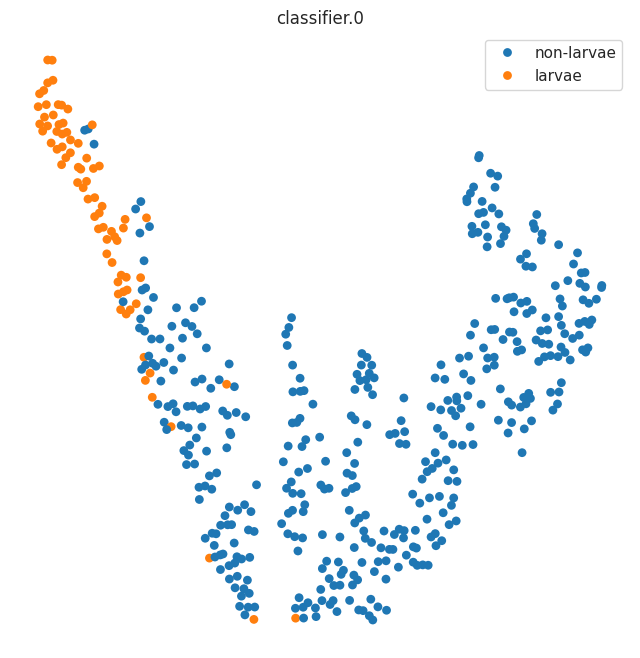

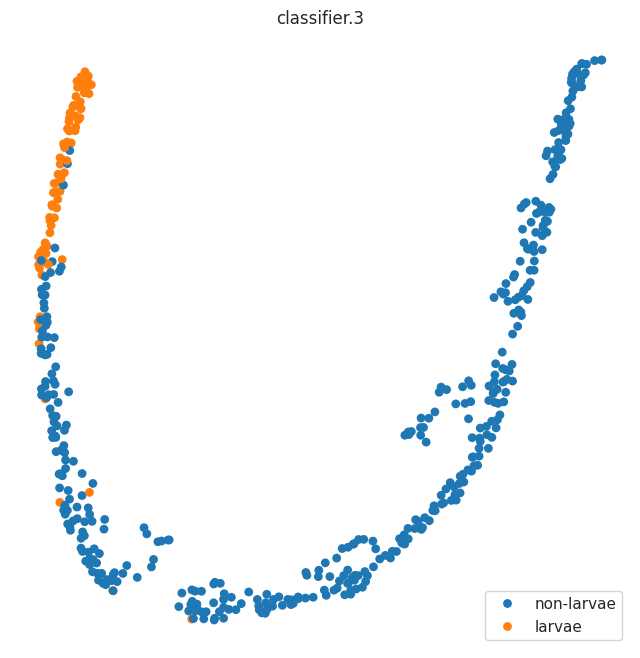

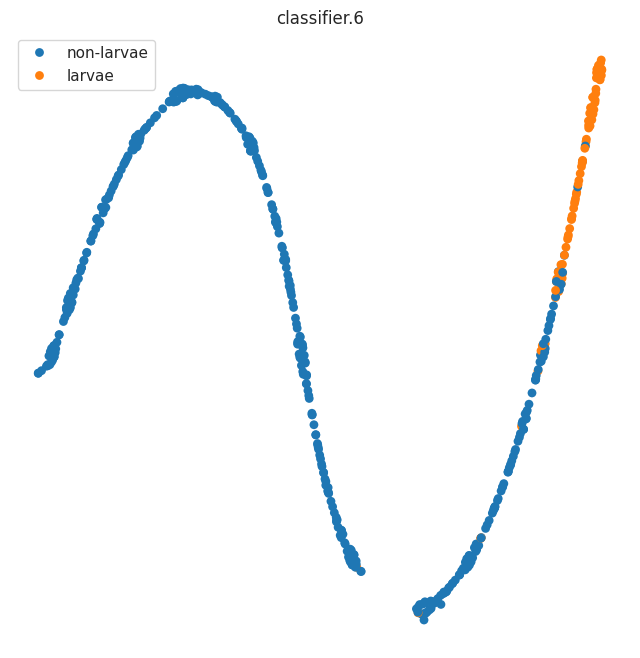

In [ ]:
# Display layer representations
visualizer_3.display_layer_representations(test_loader)

  Generating heatmap for Non-larvae...
  Predicted label is Larvae!


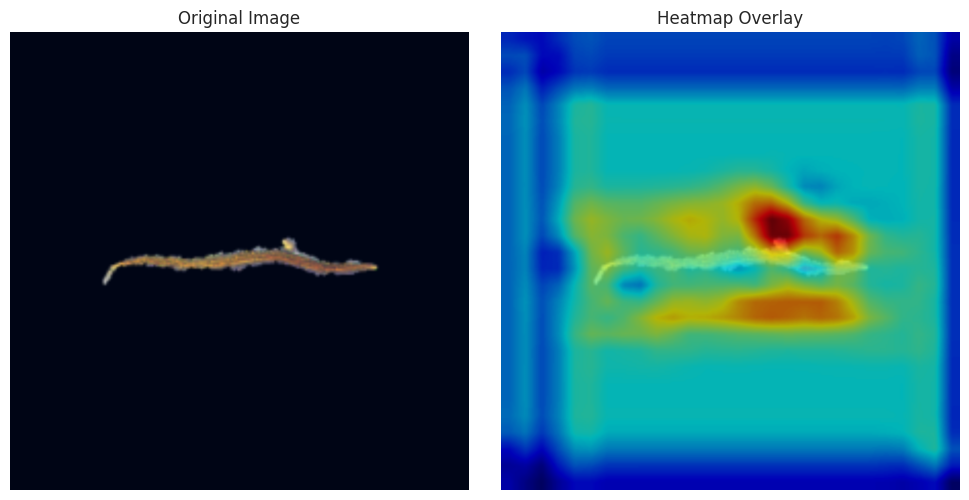

  Generating heatmap for Larvae...
  Predicted label is Larvae!


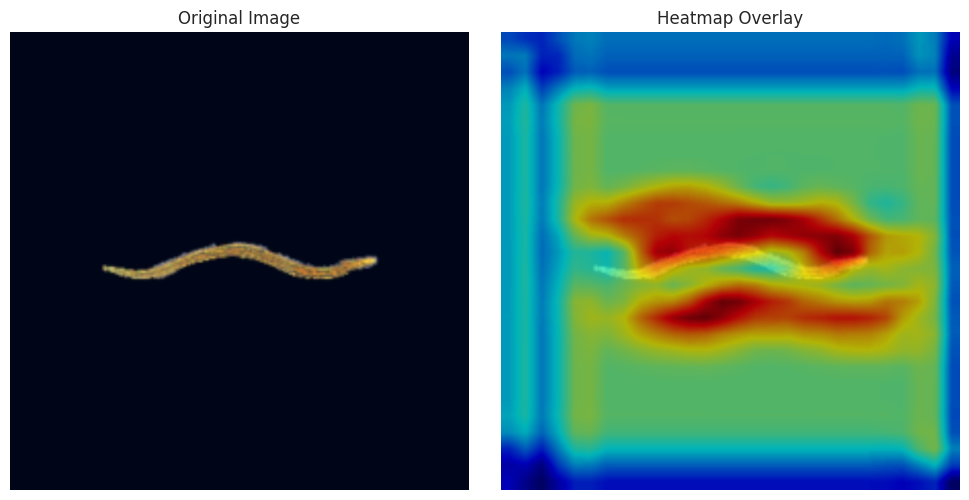

In [ ]:
# Display a heatmap for a single larvae sample and a single non-larvae sample
larvae_done = False
non_larvae_done = False
for sample_img, target in test_loader.dataset:
    if not larvae_done and target == 0:  # Larvae
        larvae_done = True
        visualizer_3.display_heatmap(sample_img, target)
    elif not non_larvae_done and target == 1:  # Non-larvae
        non_larvae_done = True
        visualizer_3.display_heatmap(sample_img, target)
    if larvae_done and non_larvae_done:
        break